In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import pdb
import os 
import data
import maml
import regressors
from collections import OrderedDict
import copy

from model import *
from utils import *

import time

In [2]:
gen = data.SinusoidGenerator(batch_size = 64,
                 num_tasks = 256,
                 x_range = (-5, 5),
                 A_range = (0.1, 5),
                 P_range = (0, np.pi))

task = gen.generate_task()
task1 = task

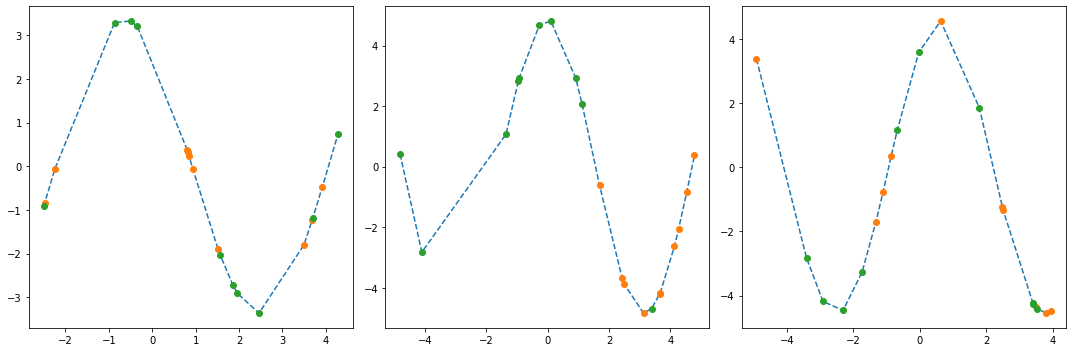

In [3]:
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows,n_cols,figsize=(5*n_cols,5*n_rows))

for idx, ax in enumerate(axes.flatten()):
    x = task['x'][idx,:,:].cpu()
    y = task['y'][idx,:,:].cpu()
    xc = task['x_context'][idx,:,:].cpu()
    yc = task['y_context'][idx,:,:].cpu()
    xt = task['x_target'][idx,:,:].cpu()
    yt = task['y_target'][idx,:,:].cpu()
    
    ax.plot(x,y,'--')
    ax.plot(xc,yc,'o')
    ax.plot(xt,yt,'o')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [39]:
%%capture
#fig, axes = plt.subplots(3,3,figsize=(20,15))
fig = plt.figure(figsize=(15,5))
for idx in range(task['x'].shape[0]):
    xc = task['x_context'][idx,:,:].cpu()
    yc = task['y_context'][idx,:,:].cpu()
    xt = task['x_target'][idx,:,:].cpu()
    yt = task['y_target'][idx,:,:].cpu()
    plt.plot(xc,yc,'o--')
    #ax.title.set_text(idx)
    #ax.set_xlim(-5,5)
    plt.tight_layout()

In [40]:
model = ModelMLPSinusoid().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
meta_model = maml.MAML_trainer(model, optimizer)
alpha=0.01

In [41]:
def plot_example(task, num_plots, model, epoch):
    
    fig, axes = plt.subplots(1,num_plots, figsize=(20,5))
    
    for idx, ax in enumerate(axes.flatten()):
        
        test_model = copy.deepcopy(model)
        
        x_supports = task['x_context']
        y_supports = task['y_context']

        x_queries = task['x_target']
        y_queries = task['y_target']
            
        updated_params = test_model._inner_loop_train(x_supports[idx], y_supports[idx], alpha)
        
        with torch.no_grad():
            # Collect predictions for query sets, using model updated params for specific task
            
            prior_query_predictions = test_model.regressor(x_queries[idx],OrderedDict(test_model.regressor.named_parameters()))
            prior_query_Loss = F.mse_loss(prior_query_predictions, y_queries[idx])
            
            updated_query_predictions = test_model.regressor(x_queries[idx], updated_params)
            updated_query_loss = F.mse_loss(updated_query_predictions, y_queries[idx])
            
            # Collect predictions for test set
            x_test = torch.unsqueeze(torch.tensor(np.linspace(-5,5), dtype=torch.float32, device=device),1)
            
            prior_predictions = test_model.regressor(x_test,OrderedDict(test_model.regressor.named_parameters()))
            updated_predictions = test_model.regressor(x_test,updated_params)
        
        ax.plot(x_supports[idx].cpu(),y_supports[idx].cpu(), 'o')
        ax.plot(x_queries[idx].cpu(),y_queries[idx].cpu(), 'o')
        
        ax.plot(x_queries[idx].cpu(), prior_query_predictions.cpu(), 'xg')
        ax.plot(x_test.cpu(), prior_predictions.cpu(), '--g')
        
        ax.plot(x_queries[idx].cpu(), updated_query_predictions.cpu(), 'xb')
        ax.plot(x_test.cpu(), updated_predictions.cpu(), '--b')
        
        ax.set_title("Epoch: {}: prior loss {:.4f}: updated loss {:.4f}".format(epoch, prior_query_Loss, updated_query_loss))
    
    plt.show()

Epoch : 0 ¦ Prior loss : 118.95 ¦ Updated loss : 113.52 ¦ Time : 1.91


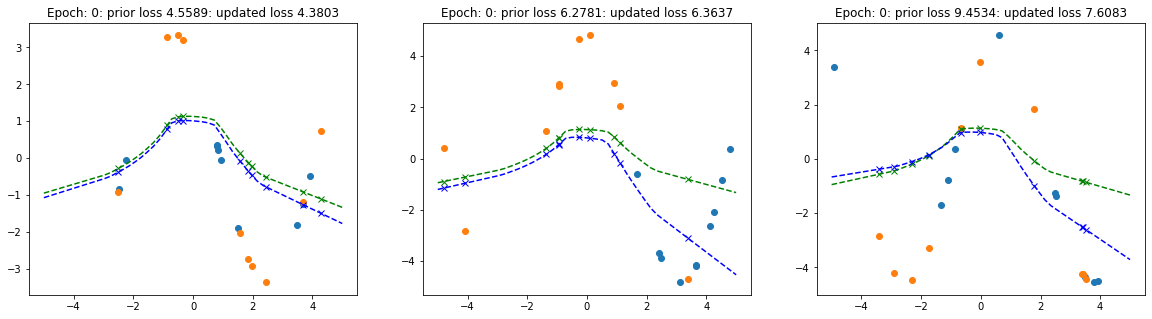

Epoch : 1 ¦ Prior loss : 112.84 ¦ Updated loss : 104.47 ¦ Time : 1.91
Epoch : 2 ¦ Prior loss : 101.56 ¦ Updated loss : 90.99 ¦ Time : 1.90
Epoch : 3 ¦ Prior loss : 106.01 ¦ Updated loss : 86.01 ¦ Time : 1.90
Epoch : 4 ¦ Prior loss : 99.82 ¦ Updated loss : 70.06 ¦ Time : 1.90
Epoch : 5 ¦ Prior loss : 102.05 ¦ Updated loss : 65.10 ¦ Time : 1.90
Epoch : 6 ¦ Prior loss : 99.90 ¦ Updated loss : 58.69 ¦ Time : 1.90
Epoch : 7 ¦ Prior loss : 106.83 ¦ Updated loss : 52.18 ¦ Time : 1.90
Epoch : 8 ¦ Prior loss : 120.49 ¦ Updated loss : 48.11 ¦ Time : 1.90
Epoch : 9 ¦ Prior loss : 119.33 ¦ Updated loss : 37.55 ¦ Time : 1.91
Epoch : 10 ¦ Prior loss : 105.79 ¦ Updated loss : 32.96 ¦ Time : 1.91


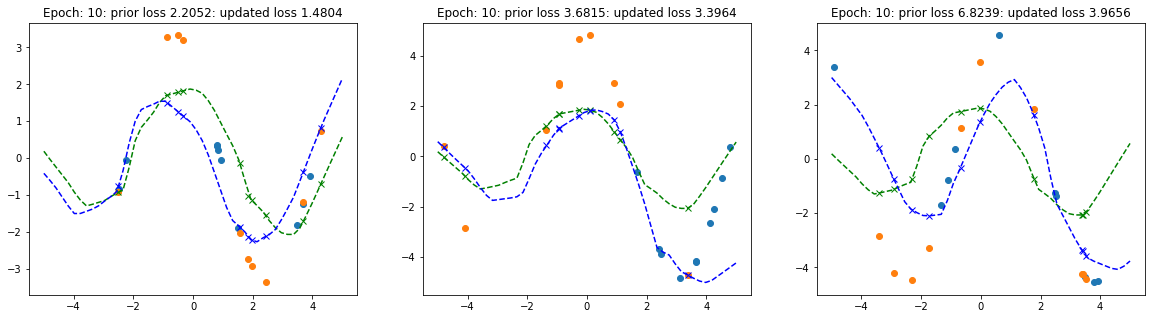

Epoch : 11 ¦ Prior loss : 115.79 ¦ Updated loss : 33.80 ¦ Time : 1.92
Epoch : 12 ¦ Prior loss : 123.05 ¦ Updated loss : 30.90 ¦ Time : 1.92
Epoch : 13 ¦ Prior loss : 122.56 ¦ Updated loss : 29.37 ¦ Time : 1.90
Epoch : 14 ¦ Prior loss : 154.50 ¦ Updated loss : 33.10 ¦ Time : 1.90
Epoch : 15 ¦ Prior loss : 124.92 ¦ Updated loss : 28.14 ¦ Time : 1.90
Epoch : 16 ¦ Prior loss : 118.27 ¦ Updated loss : 25.60 ¦ Time : 1.90
Epoch : 17 ¦ Prior loss : 161.51 ¦ Updated loss : 30.24 ¦ Time : 1.92
Epoch : 18 ¦ Prior loss : 120.43 ¦ Updated loss : 25.02 ¦ Time : 1.90
Epoch : 19 ¦ Prior loss : 155.91 ¦ Updated loss : 32.50 ¦ Time : 1.90
Epoch : 20 ¦ Prior loss : 117.35 ¦ Updated loss : 27.16 ¦ Time : 1.90


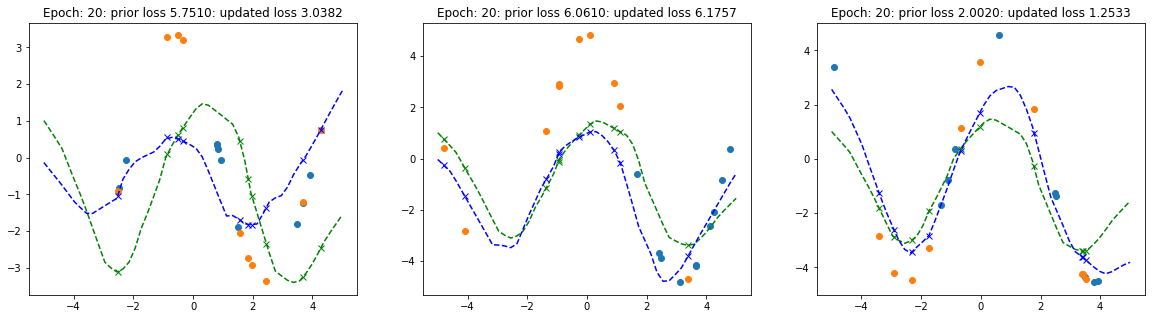

Epoch : 21 ¦ Prior loss : 128.32 ¦ Updated loss : 26.53 ¦ Time : 1.89
Epoch : 22 ¦ Prior loss : 133.38 ¦ Updated loss : 25.15 ¦ Time : 1.89
Epoch : 23 ¦ Prior loss : 194.17 ¦ Updated loss : 33.31 ¦ Time : 1.89
Epoch : 24 ¦ Prior loss : 166.46 ¦ Updated loss : 31.09 ¦ Time : 1.90
Epoch : 25 ¦ Prior loss : 154.15 ¦ Updated loss : 31.75 ¦ Time : 1.91
Epoch : 26 ¦ Prior loss : 141.95 ¦ Updated loss : 29.32 ¦ Time : 1.90
Epoch : 27 ¦ Prior loss : 137.70 ¦ Updated loss : 26.52 ¦ Time : 1.91
Epoch : 28 ¦ Prior loss : 120.49 ¦ Updated loss : 22.65 ¦ Time : 1.91
Epoch : 29 ¦ Prior loss : 148.99 ¦ Updated loss : 23.79 ¦ Time : 1.91
Epoch : 30 ¦ Prior loss : 144.06 ¦ Updated loss : 24.23 ¦ Time : 1.91


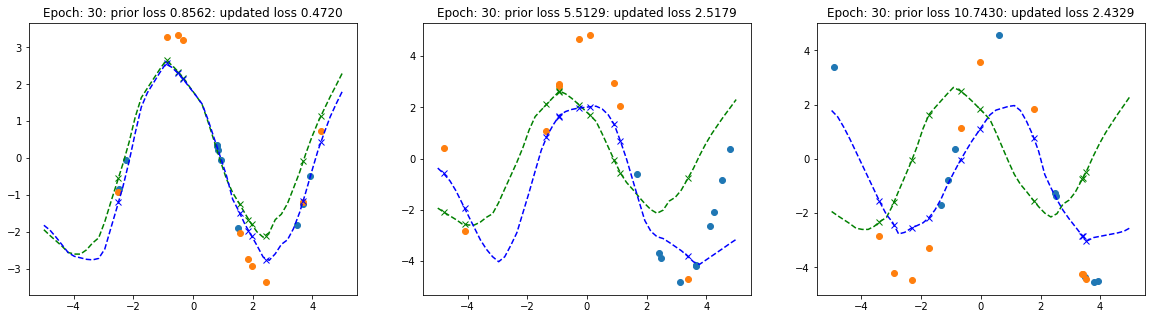

Epoch : 31 ¦ Prior loss : 111.46 ¦ Updated loss : 21.34 ¦ Time : 1.91
Epoch : 32 ¦ Prior loss : 150.06 ¦ Updated loss : 25.14 ¦ Time : 1.91
Epoch : 33 ¦ Prior loss : 177.80 ¦ Updated loss : 25.74 ¦ Time : 1.94
Epoch : 34 ¦ Prior loss : 131.84 ¦ Updated loss : 23.24 ¦ Time : 1.91
Epoch : 35 ¦ Prior loss : 196.30 ¦ Updated loss : 28.98 ¦ Time : 1.91
Epoch : 36 ¦ Prior loss : 162.55 ¦ Updated loss : 25.06 ¦ Time : 1.91
Epoch : 37 ¦ Prior loss : 164.57 ¦ Updated loss : 28.60 ¦ Time : 1.91
Epoch : 38 ¦ Prior loss : 158.89 ¦ Updated loss : 30.21 ¦ Time : 1.91
Epoch : 39 ¦ Prior loss : 190.20 ¦ Updated loss : 31.04 ¦ Time : 1.90
Epoch : 40 ¦ Prior loss : 156.42 ¦ Updated loss : 25.93 ¦ Time : 1.90


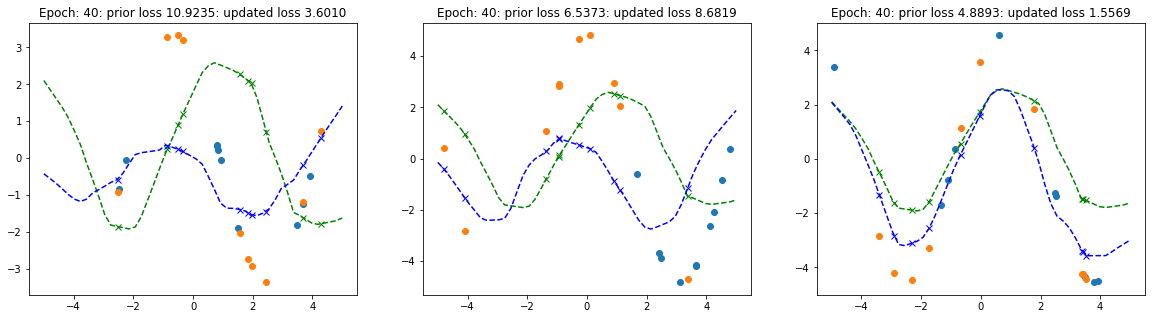

Epoch : 41 ¦ Prior loss : 160.29 ¦ Updated loss : 25.20 ¦ Time : 1.90
Epoch : 42 ¦ Prior loss : 108.55 ¦ Updated loss : 20.58 ¦ Time : 1.90
Epoch : 43 ¦ Prior loss : 125.34 ¦ Updated loss : 22.98 ¦ Time : 1.90
Epoch : 44 ¦ Prior loss : 161.30 ¦ Updated loss : 25.65 ¦ Time : 1.90
Epoch : 45 ¦ Prior loss : 128.10 ¦ Updated loss : 20.84 ¦ Time : 1.91
Epoch : 46 ¦ Prior loss : 129.43 ¦ Updated loss : 21.39 ¦ Time : 1.91
Epoch : 47 ¦ Prior loss : 158.08 ¦ Updated loss : 23.88 ¦ Time : 1.90
Epoch : 48 ¦ Prior loss : 134.84 ¦ Updated loss : 19.93 ¦ Time : 1.90
Epoch : 49 ¦ Prior loss : 160.02 ¦ Updated loss : 25.16 ¦ Time : 1.91


In [42]:
num_epochs = 50
gen.num_tasks = 32#512
gen.batch_size = 32

losses = []
prior_losses = []
avg_loss = RunningAverage()
avg_prior_loss = RunningAverage()

for epoch in range(num_epochs):
    
    start_time = time.time()
    avg_loss.reset()
    avg_prior_loss.reset()
    
    for idx, task in enumerate(gen):
        
        loss, prior_loss = meta_model.outer_loop_train(task['x_context'],
                          task['y_context'],
                          task['x_target'],
                          task['y_target'])
        
        with torch.no_grad():
            avg_loss.update(loss)
            avg_prior_loss.update(prior_loss)
        
    losses.append(avg_loss.avg)
    prior_losses.append(avg_prior_loss.avg)
    elapsed_time = time.time() - start_time
    print(f"Epoch : {epoch} ¦ Prior loss : {float(avg_prior_loss.avg):.2f} ¦ Updated loss : {float(avg_loss.avg):.2f} ¦ Time : {elapsed_time:.2f}")

    if (epoch % 10) == 0:
        num_plots = 3
        plot_example(task1, num_plots, meta_model, epoch)

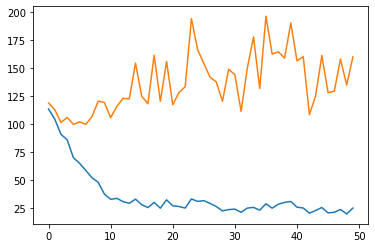

In [43]:
plt.plot(losses)
plt.plot(prior_losses)
plt.show()

In [57]:
a = torchmeta.toy.Sinusoid(num_samples_per_task=10, num_tasks=10, noise_std=None)

In [58]:
a.sample_task()

In [ ]:
def test(task, idx, model, optimizer, epoch):
    
    xc = task['x_context'][idx,:,:]
    yc = task['y_context'][idx,:,:]
    xt = task['x_target'][idx,:,:]
    yt = task['y_target'][idx,:,:]
    
    model.train()    
    # Forward pass using support sets
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    predictions = model(xc)
    loss = F.mse_loss(predictions, yc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        pred = model(xt)
        after_loss = F.mse_loss(predictions, yt)
    return pred, loss, after_loss


def test_inner_loop(task, idx, model, epoch, alpha=alpha):
    
    xc = task['x_context'][idx,:,:]
    yc = task['y_context'][idx,:,:]
    xt = task['x_target'][idx,:,:]
    yt = task['y_target'][idx,:,:]
    
    # Copy regressor to store updated params-> we don't want to update the actual meta-model
    updated_model = copy.deepcopy(model)
    #updated_model_params = updated_model.named_parameters()
    
    # Forward pass using support sets
    pred_c = updated_model(xc)
    pred_t_before = updated_model(xt)
    
    loss_target = F.mse_loss(pred_t_before, yt)
    loss_context = F.mse_loss(pred_c, yc)
    loss_context.backward()

    state_dict = updated_model.state_dict()
    
    with torch.no_grad():
        # Manual backward pass
        for name, param in updated_model.named_parameters():
            grad = param.grad
            if grad is None:
                new_param = param
            else:
                new_param = param - alpha * grad.data # gradient descent

            state_dict[name] = new_param

        updated_model.load_state_dict(state_dict)
    
        # Forward pass with updated model parameters
        pred_t = updated_model(xt)
        updated_loss_target = F.mse_loss(pred_t, yt)
        
        x_test = torch.unsqueeze(torch.tensor(np.linspace(-5,5), dtype=torch.float32, device=device),1)
        y_test = updated_model(x_test)
        
    return pred_t, loss_target, updated_loss_target, x_test, y_test